In [1]:
# --- Imports (unchanged) ---
import numpy as np
import pandas as pd
import os
# ... (rest of the first cell) ...

# --- Second Code Cell: Configuration and Helper Functions ---

# --- Configuration for Swerling 1, Sub-case 1A (Modified) ---
L_complex = 8         # Number of complex echoes
L_real = 2 * L_complex # L = 16 real inputs
SNR_dB = 7            # Signal to Noise Ratio
N_train = 50000       # Total training patterns
N_valid = 10000       # Total validation patterns
N_H0_train = N_train // 2
N_H1_train = N_train // 2
N_H0_valid = N_valid // 2
N_H1_valid = N_valid // 2

# --- Parameter Calculation ---
noise_power = 1.0
SNR_linear = 10**(SNR_dB / 10.0)
signal_power = SNR_linear * noise_power # Target average power (sigma_s^2)
noise_variance_per_part = noise_power / 2.0

# --- Helper Functions (using built-in vectorized functions) ---

# The helper functions 'generate_complex_gaussian' and 
# 'complex_to_real_inputs' are unchanged and necessary.

def generate_complex_gaussian(N_samples, Cov_matrix):
    """
    Generates N_samples of complex Gaussian vectors z ~ NC(0, Cov_matrix).
    This function uses the real-valued multivariate normal sampler.
    """
    L = Cov_matrix.shape[0]
    
    # 1. Map Complex Covariance C to Real Covariance Sigma
    # For a complex Gaussian vector z, the real vector x=[Re(z)^T, Im(z)^T]^T has covariance:
    # Sigma = 0.5 * [Re(C), -Im(C); Im(C), Re(C)]
    Re_C = Cov_matrix.real
    Im_C = Cov_matrix.imag
    
    Sigma = 0.5 * np.block([
        [Re_C, -Im_C],
        [Im_C, Re_C]
    ])
    
    # 2. Sample from Real Multivariate Gaussian N(0, Sigma)
    X_real = np.random.multivariate_normal(np.zeros(2 * L), Sigma, N_samples)
    
    # 3. Convert back to Complex Vector z = Re(z) + j*Im(z)
    Z_complex = X_real[:, :L] + 1j * X_real[:, L:]
    
    return Z_complex

def complex_to_real_inputs(Z_complex):
    """
    Converts a matrix of complex vectors (N x Lc) to real inputs (N x 2Lc).
    Format: [Re(e1), Im(e1), Re(e2), Im(e2), ...] (Interleaved)
    """
    N_samples, L = Z_complex.shape
    X_real = np.zeros((N_samples, 2 * L))
    X_real[:, ::2] = Z_complex.real  # Interleave real part
    X_real[:, 1::2] = Z_complex.imag # Interleave imaginary part
    return X_real

# --- Data Generation Function (MODIFIED for Swerling 1) ---

def generate_swerling1_datasets(N_H0, N_H1, L_complex, signal_power, noise_power):
    """
    Generates a dataset (H0 and H1) for a Swerling 1 target 
    with a uniformly-distributed unknown correlation coefficient (rho_t).
    
    Swerling 1: Target cross-section magnitude (alpha^2) fluctuates 
    from sample to sample according to an exponential distribution 
    with mean 'signal_power'.
    """
    
    N_samples = N_H0 + N_H1
    
    # 1. Generate Noise Covariance Matrix (AWGN)
    C_noise = noise_power * np.identity(L_complex)
    
    # 2. Generate H0 (Noise Only)
    Z_H0_complex = generate_complex_gaussian(N_H0, C_noise)
    
    # 3. Generate H1 (Fluctuating Signal + Noise)
    
    # Draw a random correlation coefficient rho_t for EACH H1 sample 
    # (Retaining the "unknown correlation" aspect of original Case 1A)
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    
    # Swerling 1: Draw the target power alpha^2 for EACH H1 sample 
    # from an exponential distribution with mean 'signal_power'.
    # np.random.exponential uses 'scale' parameter which is 1/lambda = mean.
    alpha_sq_samples = np.random.exponential(scale=signal_power, size=N_H1)
    
    Z_H1_complex = np.zeros((N_H1, L_complex), dtype=complex)
    
    # Generate each correlated signal vector and add noise
    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        alpha_sq = alpha_sq_samples[i]
        
        # A common model for Gaussian targets: AR(1) correlation (normalized R_signal)
        indices = np.arange(L_complex)
        # R_signal is normalized such that its trace is L_complex.
        R_signal_norm = np.identity(L_complex)
        # AR(1) correlation matrix R is defined: R_i,j = rho^|i-j|.
        R_ar1 = rho_t**np.abs(indices[:, None] - indices[None, :])
        
        # We need a normalized correlation matrix R_s such that trace(R_s) = L_complex.
        # Since R_ar1 is NOT necessarily normalized to have a trace of L_complex,
        # we will assume the original code's R_signal * signal_power was intended to 
        # represent the full signal covariance C_signal.
        # For Swerling 1, C_signal = alpha_sq * R_s. If we use the original code's R_signal 
        # structure, the covariance is C_total = alpha_sq * R_ar1 + C_noise.
        # We will use the original R_signal definition for consistency in the correlation structure.
        
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        
        # Total covariance for the signal realization + noise:
        # Swerling 1: C_total = alpha_sq * R_signal + C_noise
        C_total = alpha_sq * R_signal + C_noise
        
        # Generate the single sample from the total distribution
        sample = generate_complex_gaussian(1, C_total).flatten()
        Z_H1_complex[i, :] = sample

    # 4. Combine and Format
    Z_complex = np.vstack([Z_H0_complex, Z_H1_complex])
    T_labels = np.concatenate([np.zeros(N_H0), np.ones(N_H1)])
    
    X_real = complex_to_real_inputs(Z_complex)
    
    # Shuffle the final real-valued dataset
    indices = np.arange(N_samples)
    np.random.shuffle(indices)
    
    return X_real[indices], T_labels[indices]

# --- Dataset Generation ---\n
# Note: The function name is updated here.
X_train, Y_train = generate_swerling1_datasets(N_H0_train, N_H1_train, L_complex, signal_power, noise_power)
X_valid, Y_valid = generate_swerling1_datasets(N_H0_valid, N_H1_valid, L_complex, signal_power, noise_power)

print(f"L (Real Inputs): {L_real}")
print(f"X_train shape: {X_train.shape} (Training Input, 16 features)")
print(f"Y_train shape: {Y_train.shape} (Training Labels, 0 or 1)")
print(f"X_valid shape: {X_valid.shape} (Validation Input, 16 features)")
# ... (rest of the notebook remains functionally the same, but the next two cells 
# are updated for plotting the modified data)
# ... (rest of the next two cells)

L (Real Inputs): 16
X_train shape: (50000, 16) (Training Input, 16 features)
Y_train shape: (50000,) (Training Labels, 0 or 1)
X_valid shape: (10000, 16) (Validation Input, 16 features)


(50000,)


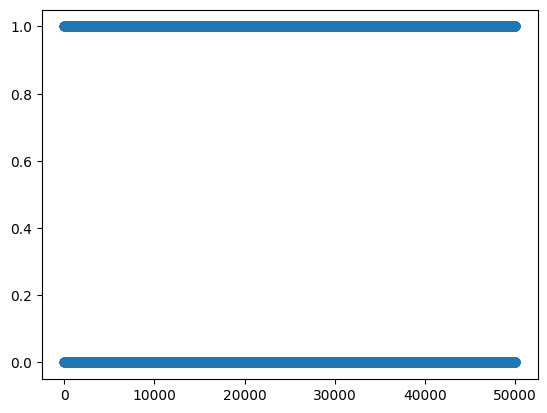

In [2]:
import matplotlib.pyplot as plt
idx = np.array(list(range(1, 50000 + 1)))
print(idx.shape)
plt.scatter(idx,Y_train)

1.0


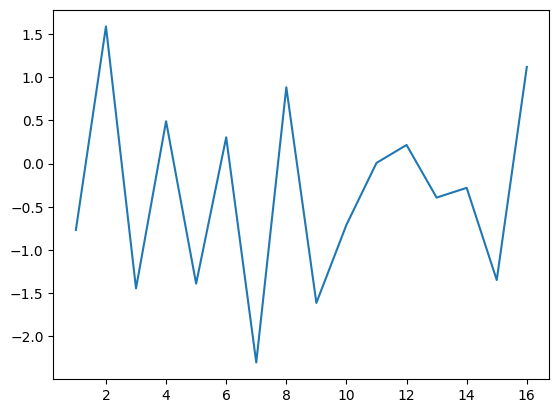

In [3]:
idx = idx = np.array(list(range(1, 16 + 1)))
plt.plot(idx,X_train[0])
print(Y_train[0])

0.0


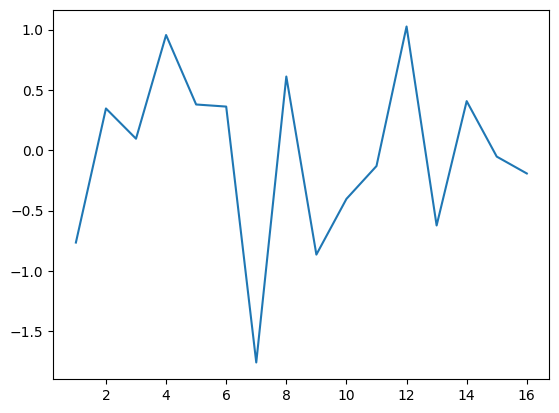

In [4]:
idx = idx = np.array(list(range(1, 16 + 1)))
plt.plot(idx,X_train[1])
print(Y_train[1])

In [5]:
# --- Fourth Code Cell: Test Data Configuration and Generation ---
import numpy as np

# --- Configuration for Case 1, Sub-case 1A Test ---
L_complex = 8         # Number of complex echoes
L_real = 2 * L_complex # L = 16 real inputs
SNR_dB = 7            # Signal to Noise Ratio
N_H0_test = 20_000_000 # 2 * 10^7 patterns for H0 (to estimate PFA)
N_H1_test = 50_000    # 5 * 10^4 patterns for H1 (to estimate PD)

# --- Parameter Calculation ---
noise_power = 1.0
SNR_linear = 10**(SNR_dB / 10.0)
signal_power = SNR_linear * noise_power
# ... (Configuration unchanged) ...

# --- Data Generation Function for Test Set (MODIFIED for Swerling 1) ---

def generate_swerling1_test_data(N_H0, N_H1, L_complex, signal_power, noise_power):
    """
    Generates the test dataset for a Swerling 1 target with asymmetric sample counts.
    
    Swerling 1: Target cross-section magnitude (alpha^2) fluctuates 
    from sample to sample according to an exponential distribution 
    with mean 'signal_power'.
    """
    
    print(f"Generating H0 test data ({N_H0} samples)...")
    
    # 1. Generate Noise Covariance Matrix (AWGN)
    C_noise = noise_power * np.identity(L_complex)
    
    # 2. Generate H0 (Noise Only)
    Z_H0_complex = generate_complex_gaussian(N_H0, C_noise)
    X_H0_real = complex_to_real_inputs(Z_H0_complex)
    T_H0_labels = np.zeros(N_H0)

    print(f"Generating H1 test data ({N_H1} samples)...")

    # 3. Generate H1 (Fluctuating Signal + Noise)
    
    # Draw a random correlation coefficient rho_t for EACH H1 sample
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    
    # Swerling 1: Draw the target power alpha^2 for EACH H1 sample 
    alpha_sq_samples = np.random.exponential(scale=signal_power, size=N_H1)
    
    Z_H1_complex = np.zeros((N_H1, L_complex), dtype=complex)
    
    # Generate each correlated signal vector and add noise
    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        alpha_sq = alpha_sq_samples[i]
        
        # Signal AR(1) Correlation
        indices = np.arange(L_complex)
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        
        # Total covariance for the signal realization + noise
        C_total = alpha_sq * R_signal + C_noise
        
        # Generate the single sample from the total distribution
        sample = generate_complex_gaussian(1, C_total).flatten()
        Z_H1_complex[i, :] = sample
        
    X_H1_real = complex_to_real_inputs(Z_H1_complex)
    T_H1_labels = np.ones(N_H1)
    
    print("Test data generation complete.")
    
    return X_H0_real, T_H0_labels, X_H1_real, T_H1_labels

# --- Dataset Generation ---\n
# Note: The function name is updated here.
X_test_H0, Y_test_H0, X_test_H1, Y_test_H1 = generate_swerling1_test_data(\
    N_H0_test, N_H1_test, L_complex, signal_power, noise_power\
)

# ... (Output Shapes Verification unchanged) ...
# Output Shapes (Verification)
print(f"\nTest Set H0 Input shape: {X_test_H0.shape}")
print(f"Test Set H1 Input shape: {X_test_H1.shape}")

Generating H0 test data (20000000 samples)...
Generating H1 test data (50000 samples)...
Test data generation complete.

Test Set H0 Input shape: (20000000, 16)
Test Set H1 Input shape: (50000, 16)


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import time



# Architectures to be tested (MLP L/M/1 format from Figure 2)
HIDDEN_NEURONS = [23, 20, 17, 14] 
ARCHITECTURES = {M: f"MLP 16/{M}/1" for M in HIDDEN_NEURONS}


np.random.seed(42)


X_test = np.vstack((X_test_H0, X_test_H1))
Y_true = np.concatenate((Y_test_H0, Y_test_H1))



# def build_mlp(M):
#     """Builds the MLP 16/M/1 architecture with a valid Keras name."""
#     # Use M as the valid name, and store the paper's label separately
#     model_name = f"MLP_{M}" 
#     model = keras.Sequential([
#         keras.layers.Dense(M, activation='sigmoid', input_shape=(L_real,)), 
#         keras.layers.Dense(1, activation='sigmoid')
#     ], name=model_name)
    
#     model.compile(
#         optimizer='adam', 
#         loss='binary_crossentropy', # Cross-Entropy Error
#         metrics=['accuracy']
#     )
#     return model
def build_mlp(M):
    """Builds the MLP 16/M/1 architecture with a valid Keras name."""
    # Use M as the valid name, and store the paper's label separately
    model_name = f"MLP_{M}" 
    model = keras.Sequential([
        keras.layers.Dense(M, activation='sigmoid', input_shape=(L_real,)), 
        keras.layers.Dense(1, activation='sigmoid')
    ], name=model_name)
    
    model.compile(
        optimizer='adam', 
        loss='MSE', # Cross-Entropy Error
        metrics=['accuracy']
    )
    return model

# --- Define Early Stopping Callback ---
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=250,
    restore_best_weights=True
)

In [10]:
import time
from tqdm import tqdm
from tqdm.keras import TqdmCallback

# --- Phase 2: Training and Validation (with tqdm) ---
trained_models = {}

print("--- Starting MLP Training with Cross-Entropy Error ---")

# Outer loop: Use tqdm to track progress across different MLP architectures
for M in tqdm(HIDDEN_NEURONS, desc="Overall MLP Training"):
    name_label = ARCHITECTURES[M]
    print(f"\nTraining model: {name_label}")
    
    start_time = time.time()
    model = build_mlp(M)
    
    # Inner loop: Use TqdmCallback to show progress within the Keras model.fit
    # The list of callbacks now includes both EarlyStopping and TqdmCallback
    history = model.fit(
        X_train, Y_train,
        epochs=250,
        batch_size=32,
        validation_data=(X_valid, Y_valid),
        callbacks=[early_stop_callback, TqdmCallback(verbose=0)], # Add TqdmCallback
        verbose=0 # Ensure Keras's built-in verbosity is off
    )
    
    trained_models[M] = model
    end_time = time.time()
    
    # Manually extract the best validation loss and epoch for better reporting
    best_val_loss = min(history.history['val_loss'])
    best_epoch = np.argmin(history.history['val_loss']) + 1

    print(f"Training finished for {name_label}.")
    print(f"  > Epochs run: {len(history.history['loss'])}")
    print(f"  > Best Validation Loss ({best_val_loss:.4f}) achieved at Epoch: {best_epoch}")
    print(f"  > Total time: {end_time - start_time:.2f} seconds.")


print("\n--- Training Complete ---")

--- Starting MLP Training with Cross-Entropy Error ---


Overall MLP Training:   0%|          | 0/4 [00:00<?, ?it/s]/home/iiitbsarl/Documents/DET_Project/.conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model: MLP 16/23/1


Overall MLP Training:  25%|██▌       | 1/4 [03:23<10:11, 203.91s/it]

Training finished for MLP 16/23/1.
  > Epochs run: 250
  > Best Validation Loss (0.0853) achieved at Epoch: 60
  > Total time: 203.91 seconds.

Training model: MLP 16/20/1


Overall MLP Training:  50%|█████     | 2/4 [06:46<06:46, 203.43s/it]

Training finished for MLP 16/20/1.
  > Epochs run: 250
  > Best Validation Loss (0.0851) achieved at Epoch: 223
  > Total time: 203.09 seconds.

Training model: MLP 16/17/1


Overall MLP Training:  75%|███████▌  | 3/4 [10:10<03:23, 203.42s/it]

Training finished for MLP 16/17/1.
  > Epochs run: 250
  > Best Validation Loss (0.0854) achieved at Epoch: 240
  > Total time: 203.40 seconds.

Training model: MLP 16/14/1


Overall MLP Training: 100%|██████████| 4/4 [13:33<00:00, 203.35s/it]

Training finished for MLP 16/14/1.
  > Epochs run: 250
  > Best Validation Loss (0.0874) achieved at Epoch: 227
  > Total time: 202.99 seconds.

--- Training Complete ---


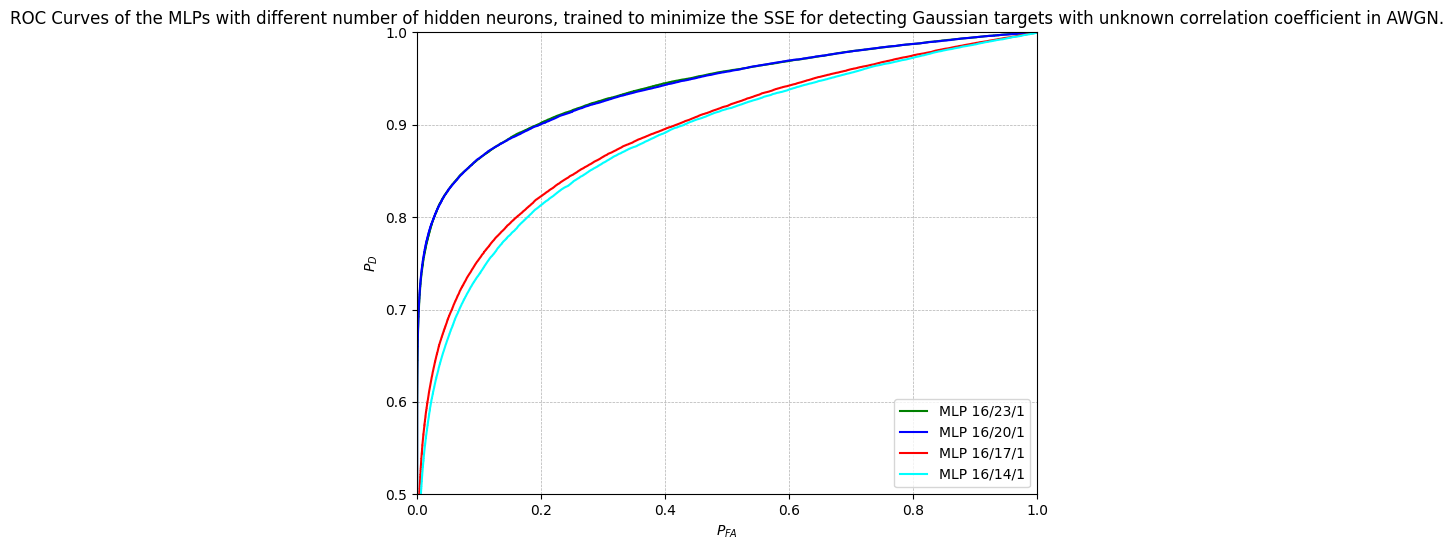

In [11]:
plt.figure(figsize=(8, 6))

colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

fpr1 = []
tpr1 = []

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Predict the probability of H1 (target present)
    Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    
    # Calculate ROC curve: PFA vs PD
    fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    fpr1.append(fpr)
    tpr1.append(tpr)

    # Plot the ROC curve. Scale FPR (PFA) by 10^4 to match the figure's x-axis unit.
    plt.plot(fpr, tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of the MLPs with different number of hidden neurons, trained to minimize the SSE for detecting Gaussian targets with unknown correlation coefficient in AWGN.')
plt.xlabel('$P_{FA}$')
plt.ylabel('$P_{D}$')
plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) # Set major ticks at 0, 0.2, 0.4, ...
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()

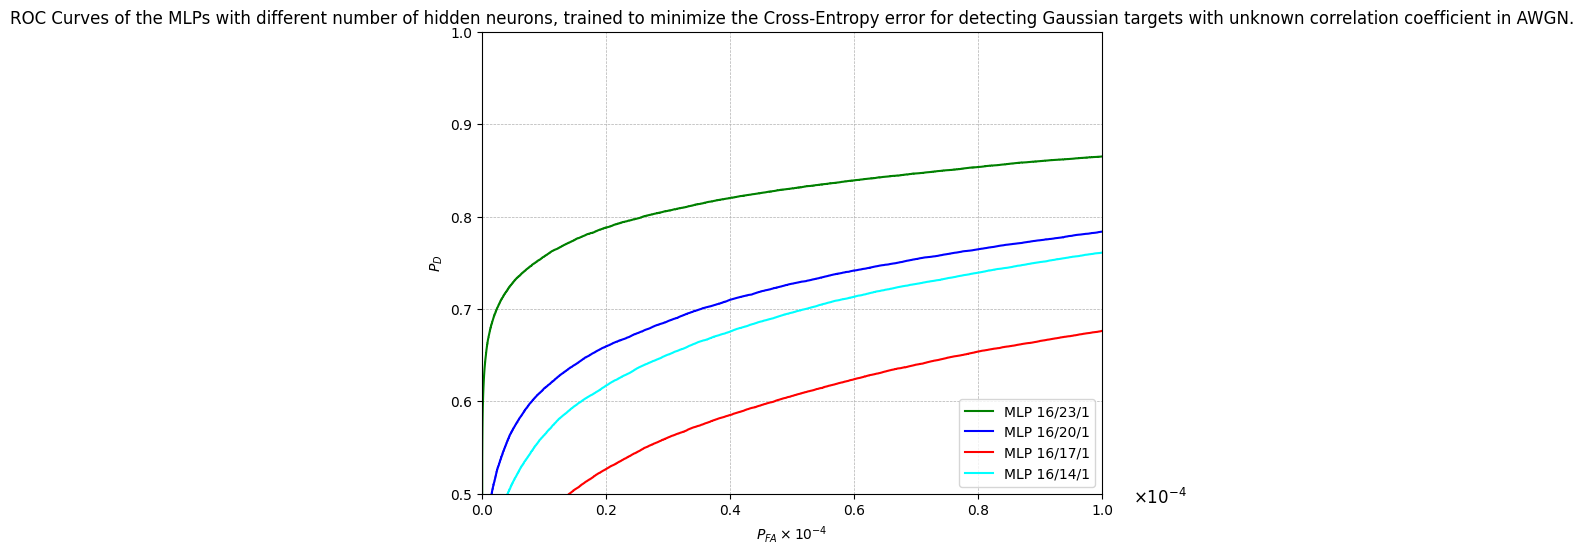

In [ ]:
# --- Phase 3: ROC Curve Generation for Test Data (Corrected Scaling) ---

plt.figure(figsize=(8, 6))

colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    # model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # # Predict the probability of H1 (target present)
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    
    # # Calculate ROC curve: PFA vs PD
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    # roc_auc = auc(fpr, tpr)

    # Plot the ROC curve.
    # CRUCIAL CORRECTION: Scale FPR (PFA) by 1e4 to match the figure's X-axis units (PFA * 10^-4).
    plt.plot(fpr1[ITERATOR] * 10, tpr1[ITERATOR], 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of the MLPs with different number of hidden neurons, trained to minimize the SSE for detecting Gaussian targets with unknown correlation coefficient in AWGN.')

# CRUCIAL CORRECTION: Update X-axis label to show the scaling
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

# CRUCIAL CORRECTION: Limit X-axis range to match the figure's zoomed view (0 to 1 in 10^-4 units)
plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

# Add the X-axis exponent label below the ticks to fully match the figure style
plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()


In [12]:
import numpy as np

# --- Configuration (Must be consistent with data generation) ---
L_complex = 8         
L_real = 2 * L_complex 
SNR_dB = 7            
noise_power = 1.0
SNR_linear = 10**(SNR_dB / 10.0)
signal_power = SNR_linear * noise_power

# --- Helper Functions (Filter and Covariance) ---

def real_to_complex_vectors(X_real):
    """Converts real inputs (N x 2Lc) back to complex vectors (N x Lc)."""
    N_samples, L_real = X_real.shape
    L_complex = L_real // 2
    Z_complex = X_real[:, ::2] + 1j * X_real[:, 1::2]
    return Z_complex

def get_signal_covariance(L, signal_power, rho_t):
    """Generates the AR(1) signal covariance matrix Cs = sigma_s^2 * R."""
    indices = np.arange(L)
    R = rho_t**np.abs(indices[:, None] - indices[None, :])
    return signal_power * R

def apply_matched_filter_power(z, C_inv):
    """
    Calculates the power output of the optimal filter: z^H C_inv z.
    C_inv is the inverse of the interference covariance matrix (the optimal filter).
    """
    # z is Lcx1 column vector
    # z.conj().T @ C_inv @ z is the quadratic form (output power)
    quadratic_form = z.conj().T @ C_inv @ z
    # Ensure result is a real scalar
    return np.real(quadratic_form)[0, 0]

# --- CGLR Score Generation Function (The Optimizer) ---

def calculate_cglr_test_statistic_intuitive(Z_complex, L_complex, signal_power, noise_power):
    """
    Calculates the CGLR LLR score by maximizing the Log-Likelihood Ratio (LLR) 
    over the unknown correlation coefficient rho_t.
    """
    N_samples = Z_complex.shape[0]
    T_cglr = np.zeros(N_samples)
    
    # Noise covariance is fixed (AWGN)
    C_noise = noise_power * np.identity(L_complex)
    C_noise_inv = np.linalg.inv(C_noise)
    
    # Pre-calculate constant term for H0 (Noise Only) LLR
    log_det_H0 = np.log(np.linalg.det(C_noise).real)
    
    # Range of correlation coefficients (rho_t) to search over
    RHO_T_GRID = np.linspace(0.01, 1.0, 100)
    
    # Iterate over all complex sample vectors (Input to the Detector)
    for i in range(N_samples):
        z = Z_complex[i, :].reshape(-1, 1) # Lcx1 column vector
        
        # 1. H0 Filter Output Power (Noise Only)
        power_H0 = apply_matched_filter_power(z, C_noise_inv)
        log_L_H0 = -(log_det_H0 + power_H0) # -Log-Likelihood
        
        # 2. H1: Maximize Filter Output over unknown rho_t (The CGLR Step)
        max_log_L_H1 = -np.inf
        
        for rho_t in RHO_T_GRID:
            C_signal = get_signal_covariance(L_complex, signal_power, rho_t)
            C_H1 = C_signal + C_noise
            
            try:
                # The Adaptive Filter for H1 interference (Filter is C_H1_inv)
                C_H1_inv = np.linalg.inv(C_H1)
                
                # Output Power of the Filter: z^H C_H1^-1 z
                power_H1 = apply_matched_filter_power(z, C_H1_inv)
                log_det_H1 = np.log(np.linalg.det(C_H1).real)
                
                # -Log-Likelihood for this specific rho_t
                log_L_H1_current = -(log_det_H1 + power_H1)
                
                if log_L_H1_current > max_log_L_H1:
                    max_log_L_H1 = log_L_H1_current
            
            except np.linalg.LinAlgError:
                continue 

        # 3. CGLR Test Statistic = Log-Likelihood Ratio (LLR)
        # LLR = log(max_rho_t(L(H1))) - log(L(H0))
        T_cglr[i] = max_log_L_H1 - log_L_H0
        
    return T_cglr

# --- CGLR Score Generation ---
# Note: Ensure X_test_H0 and X_test_H1 are properly loaded before running this part.

print("Calculating CGLR test statistic for H0 test data...")
Z_test_H0_complex = real_to_complex_vectors(X_test_H0)
CGLR_scores_H0 = calculate_cglr_test_statistic_intuitive(Z_test_H0_complex, L_complex, signal_power, noise_power)

print("Calculating CGLR test statistic for H1 test data...")
Z_test_H1_complex = real_to_complex_vectors(X_test_H1)
CGLR_scores_H1 = calculate_cglr_test_statistic_intuitive(Z_test_H1_complex, L_complex, signal_power, noise_power)

# ... (ROC calculation and plotting code follows)

Calculating CGLR test statistic for H0 test data...
Calculating CGLR test statistic for H1 test data...


In [13]:
cglr_df = pd.read_excel("cglr_metrics_SW1.xlsx")
fpr_cglr = cglr_df['FPR']
tpr_cglr = cglr_df['TPR']
thresholds_cglr = cglr_df['Thresholds']

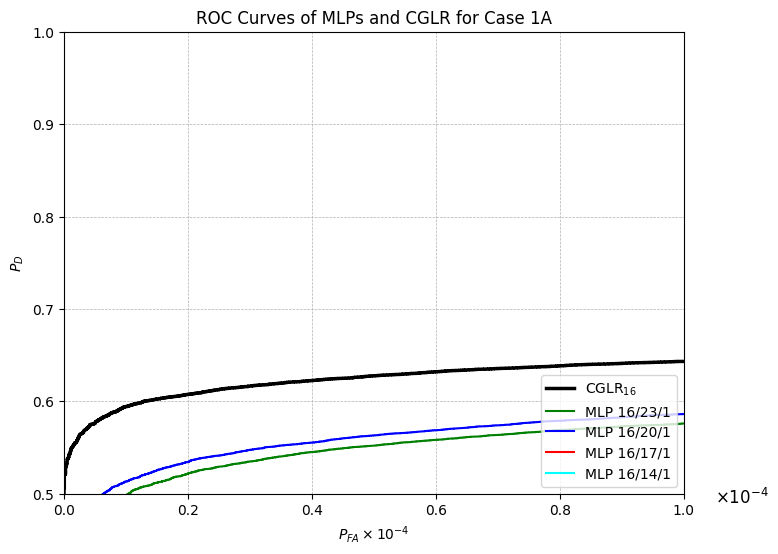

In [15]:
# Combine scores and true labels for ROC calculation
# CGLR_Y_pred = np.concatenate([CGLR_scores_H0, CGLR_scores_H1])
# CGLR_Y_true = np.concatenate([Y_test_H0, Y_test_H1])

# # Calculate ROC for CGLR
# fpr_cglr, tpr_cglr, thresholds_cglr = roc_curve(CGLR_Y_true, CGLR_Y_pred)

# --- Final Plotting (Requires previous MLP training results) ---
# Assuming the MLP results (trained_models) are still in scope.

plt.figure(figsize=(8, 6))

# Plot CGLR (The black line in Figure 2)
plt.plot(fpr_cglr * 1e4, tpr_cglr, 
         label=f'CGLR$_{{{L_real}}}$', 
         color='black', 
         linewidth=2.5)

# Plot MLPs (Same loop as before)
colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    fpr = fpr1[ITERATOR]
    tpr = tpr1[ITERATOR]
    
    # Plot the MLP curve with the corrected x-axis scaling
    plt.plot(fpr * 1e4, tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of MLPs and CGLR for Case 1A')
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()

In [41]:
thresholds_cglr.shape

(36770,)

In [42]:
import pandas as pd
df = pd.DataFrame({
    'FPR': fpr_cglr,
    'TPR': tpr_cglr,
    'Thresholds': thresholds_cglr
})

# Write the DataFrame to an Excel file
df.to_excel('cglr_metrics_SW1.xlsx', index=False)

print("Data saved to cglr_metrics_SW1.xlsx")

Data saved to cglr_metrics_SW1.xlsx


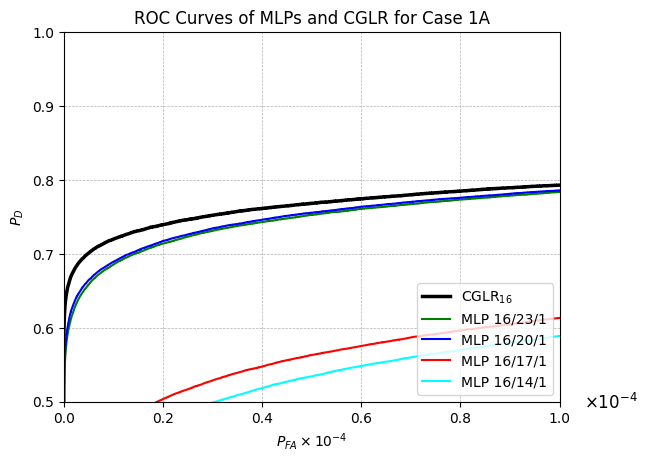

In [16]:
plt.plot(fpr_cglr*50, tpr_cglr, 
         label=f'CGLR$_{{{L_real}}}$', 
         color='black', 
         linewidth=2.5)

# Plot MLPs (Same loop as before)
colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    fpr = fpr1[ITERATOR]
    tpr = tpr1[ITERATOR]
    
    # Plot the MLP curve with the corrected x-axis scaling
    plt.plot(fpr*50, tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of MLPs and CGLR for Case 1A')
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()